In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/content/QVI_data.csv')
df.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


**Select control stores**

The client has selected store numbers 77, 86 and 88 as trial stores and want control stores to be established
stores that are operational for the entire observation period.

I will first create the metrics of interest and filter to stores that are present throughout the pre-trial period


In [3]:
df['DATE'] = pd.to_datetime(df['DATE'])  # Convert DATE column to datetime format

#Extract year and month and present in the form YYYYMM
df['YEARMONTH'] = df['DATE'].dt.year * 100 + df['DATE'].dt.month

#measures over time for each store
measure_over_time = (df.groupby(['STORE_NBR', 'YEARMONTH']).agg(
                      totSales = ('TOT_SALES', 'sum'),
                      nCustomers=('LYLTY_CARD_NBR', pd.Series.nunique), #Number of unique customers per store per month
                      nTxnPerCust = ('TXN_ID', lambda x: x.nunique() / df.loc[x.index, 'LYLTY_CARD_NBR'].nunique()), #Avg transactions per customer per store per month
                      nChipsPerTxn = ('PROD_QTY', lambda x: x.sum() / x.nunique()), #Avg number of chips per transaction per store per month
                      avgPricePerUnit = ('TOT_SALES', lambda x: x.sum() /
                                         df.loc[x.index, 'PROD_QTY'].sum())).reset_index().sort_values(by=['STORE_NBR', 'YEARMONTH']))

# Filter to stores with full observation periods (12 months)
stores_with_full_obs = (measure_over_time.groupby('STORE_NBR').size()
                        .reset_index(name='N')
                        .query('N == 12')['STORE_NBR'])

# Filter to pre-trial period and stores with full observations
pre_trial_measures = measure_over_time[(measure_over_time['YEARMONTH'] < 201902) &
                    (measure_over_time['STORE_NBR'].isin(stores_with_full_obs))]


print(pre_trial_measures)


      STORE_NBR  YEARMONTH  totSales  nCustomers  nTxnPerCust  nChipsPerTxn  \
0             1     201807     206.9          49     1.061224          31.0   
1             1     201808     176.1          42     1.023810          18.0   
2             1     201809     278.8          59     1.050847          37.5   
3             1     201810     188.1          44     1.022727          29.0   
4             1     201811     192.6          46     1.021739          28.5   
...         ...        ...       ...         ...          ...           ...   
3159        272     201809     304.7          32     1.125000          35.5   
3160        272     201810     430.6          44     1.136364          49.5   
3161        272     201811     376.2          41     1.097561          43.5   
3162        272     201812     403.9          47     1.000000          44.5   
3163        272     201901     423.0          46     1.086957          48.0   

      avgPricePerUnit  
0            3.337097  
1  

How correlated the performance of each store is to the trial store

In [4]:
def calculate_correlation(input_table, metric_col, store_comparison):

    # an empty list to store correlation results
    correlation_results = []

    # unique store numbers
    store_numbers = input_table['STORE_NBR'].unique()

    # Loop through each potential control store
    for store in store_numbers:
        # Calculate correlation if the store is not the trial store
        corr_value = np.corrcoef(input_table.loc[input_table['STORE_NBR'] == store_comparison, metric_col],
                                  input_table.loc[input_table['STORE_NBR'] == store, metric_col])[0, 1]  # Extract the correlation value

        # Append results as a dictionary
        correlation_results.append({"Store1": store_comparison, "Store2": store, "corr_measure": corr_value})

    # Convert results to a DataFrame
    return pd.DataFrame(correlation_results)


Calculate a standardised metric based on the absolute difference between the trial store’s performance and each control store’s performance.


In [5]:
def calculate_magnitude_distance(input_table, metric_col, store_comparison):
    magnitude_results = []
    store_numbers = input_table['STORE_NBR'].unique()
    for store in store_numbers:
        # Get the YearMonth and absolute difference in the metric
        measure_diff = abs(
                          input_table.loc[input_table['STORE_NBR'] == store_comparison, metric_col].values -
                          input_table.loc[input_table['STORE_NBR'] == store, metric_col].values)
        year_months = input_table.loc[input_table['STORE_NBR'] == store_comparison, 'YEARMONTH'].values

        # Store results in a dictionary
        for ym, diff in zip(year_months, measure_diff):
            magnitude_results.append({"Store1": store_comparison,
                                      "Store2": store,
                                      "YEARMONTH": ym,
                                      "measure": diff})
    magnitude_df = pd.DataFrame(magnitude_results)

    # min and max distances per (Store1, YEARMONTH)
    min_max_dist = magnitude_df.groupby(['Store1', 'YEARMONTH'])['measure'].agg(['min', 'max']).reset_index()
    min_max_dist.rename(columns={'min': 'minDist', 'max': 'maxDist'}, inplace=True)

    # Merge with magnitude_df to standardize the measure
    merged_df = magnitude_df.merge(min_max_dist, on=['Store1', 'YEARMONTH'])

    # Calculate standardized magnitude measure (scaled between 0 and 1)
    merged_df['magnitudeMeasure'] = 1 - (merged_df['measure'] - merged_df['minDist']) / (merged_df['maxDist'] - merged_df['minDist'])

    # Compute final standardized magnitude distance per Store1-Store2 pair
    final_dist_table = merged_df.groupby(['Store1', 'Store2'])['magnitudeMeasure'].mean().reset_index()
    final_dist_table.rename(columns={'magnitudeMeasure': 'mag_measure'}, inplace=True)

    return final_dist_table

**Finding Control Stores**

Select control stores based on how similar
monthly total sales in dollar amounts and monthly number of customers are to the trial stores.

In [6]:
# Define the trial store number
trial_store = 77

#correlation for total sales and total customers
corr_nSales = calculate_correlation(pre_trial_measures, "totSales", trial_store)
corr_nCustomers = calculate_correlation(pre_trial_measures, "nCustomers", trial_store)

#magnitude distance for total sales and total customers
magnitude_nSales = calculate_magnitude_distance(pre_trial_measures, "totSales", trial_store)
magnitude_nCustomers = calculate_magnitude_distance(pre_trial_measures, "nCustomers", trial_store)

print("Correlation - Total Sales:\n", corr_nSales.head(), "\n")
print("Correlation - Total Customers:\n", corr_nCustomers.head(), "\n")
print("Magnitude Distance - Total Sales:\n", magnitude_nSales.head(), "\n")
print("Magnitude Distance - Total Customers:\n", magnitude_nCustomers.head(), "\n")


Correlation - Total Sales:
    Store1  Store2  corr_measure
0      77       1      0.075218
1      77       2     -0.263079
2      77       3      0.806644
3      77       4     -0.263300
4      77       5     -0.110652 

Correlation - Total Customers:
    Store1  Store2  corr_measure
0      77       1      0.322168
1      77       2     -0.572051
2      77       3      0.834207
3      77       4     -0.295639
4      77       5      0.370659 

Magnitude Distance - Total Sales:
    Store1  Store2  mag_measure
0      77       1     0.953285
1      77       2     0.937579
2      77       3     0.354315
3      77       4     0.177135
4      77       5     0.553043 

Magnitude Distance - Total Customers:
    Store1  Store2  mag_measure
0      77       1     0.940321
1      77       2     0.924638
2      77       3     0.345067
3      77       4     0.189579
4      77       5     0.481199 



In [7]:
# Define correlation weight
corr_weight = 0.5

#Merge correlation and magnitude scores for total sales
score_nSales = corr_nSales.merge(magnitude_nSales, on=['Store1', 'Store2'])
score_nSales['scoreNSales'] = (score_nSales['corr_measure'] * corr_weight) + \
                              (score_nSales['mag_measure'] * (1 - corr_weight))

# Merge correlation and magnitude scores for number of customers
score_nCustomers = corr_nCustomers.merge(magnitude_nCustomers, on=['Store1', 'Store2'])
score_nCustomers['scoreNCust'] = (score_nCustomers['corr_measure'] * corr_weight) + \
                                 (score_nCustomers['mag_measure'] * (1 - corr_weight))

print("Score - Total Sales:\n", score_nSales.head(), "\n")
print("Score - Total Customers:\n", score_nCustomers.head(), "\n")


Score - Total Sales:
    Store1  Store2  corr_measure  mag_measure  scoreNSales
0      77       1      0.075218     0.953285     0.514251
1      77       2     -0.263079     0.937579     0.337250
2      77       3      0.806644     0.354315     0.580479
3      77       4     -0.263300     0.177135    -0.043082
4      77       5     -0.110652     0.553043     0.221196 

Score - Total Customers:
    Store1  Store2  corr_measure  mag_measure  scoreNCust
0      77       1      0.322168     0.940321    0.631244
1      77       2     -0.572051     0.924638    0.176294
2      77       3      0.834207     0.345067    0.589637
3      77       4     -0.295639     0.189579   -0.053030
4      77       5      0.370659     0.481199    0.425929 



In [8]:
#Merge the two scores to get a final control score
score_Control = score_nSales.merge(score_nCustomers, on=['Store1', 'Store2'])

# Compute the final control score as a simple average of the two measures
score_Control['finalControlScore'] = (score_Control['scoreNSales'] * 0.5) + \
                                     (score_Control['scoreNCust'] * 0.5)

#Select the best control store (excluding the trial store itself)
control_store = score_Control[score_Control['Store1'] == trial_store].sort_values(
    by='finalControlScore', ascending=False).iloc[1]['Store2']  # Second highest-ranked store

# the selected control store
print("Selected Control Store for Trial Store", trial_store, ":", control_store)


Selected Control Store for Trial Store 77 : 233.0


Confirm whether the control store follows a similar trend to the trial store.

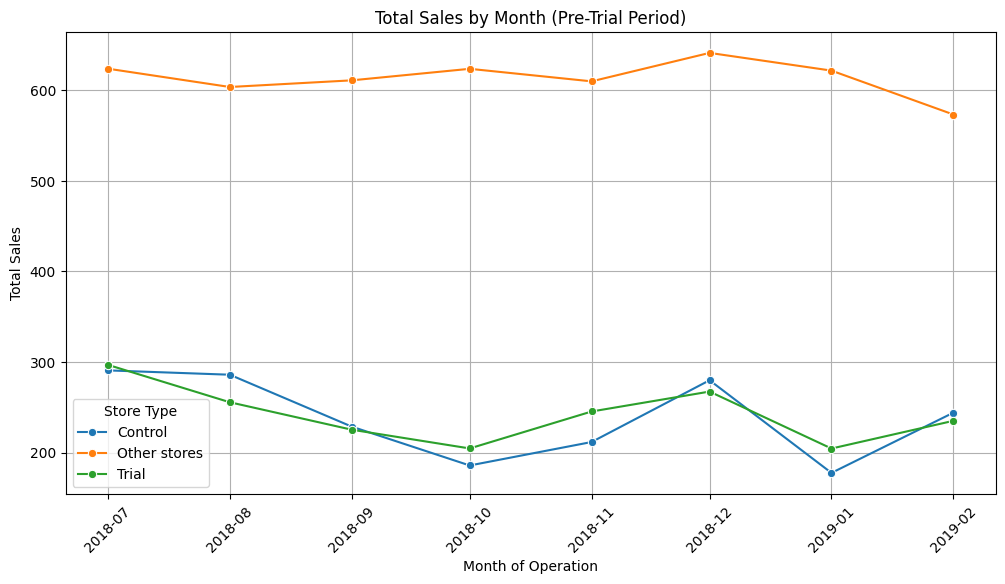

In [9]:
#Label stores as Trial, Control, or Other
measure_over_time['Store_type'] = measure_over_time['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else ('Control' if x == control_store else 'Other stores')
)

#Aggregate total sales by month and store type
pastSales = measure_over_time.groupby(['YEARMONTH', 'Store_type'], as_index=False)['totSales'].mean()

#Convert YEARMONTH to datetime format
pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'].astype(str), format='%Y%m')

#Filter for pre-trial period (before March 2019)
pastSales = pastSales[pastSales['YEARMONTH'] < 201903]

#Plot total sales trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=pastSales, x='TransactionMonth', y='totSales', hue='Store_type', marker='o')
plt.xlabel("Month of Operation")
plt.ylabel("Total Sales")
plt.title("Total Sales by Month (Pre-Trial Period)")
plt.xticks(rotation=45)
plt.legend(title="Store Type")
plt.grid(True)
plt.show()


Check if the control store's customer trends align with the trial store before the trial period.



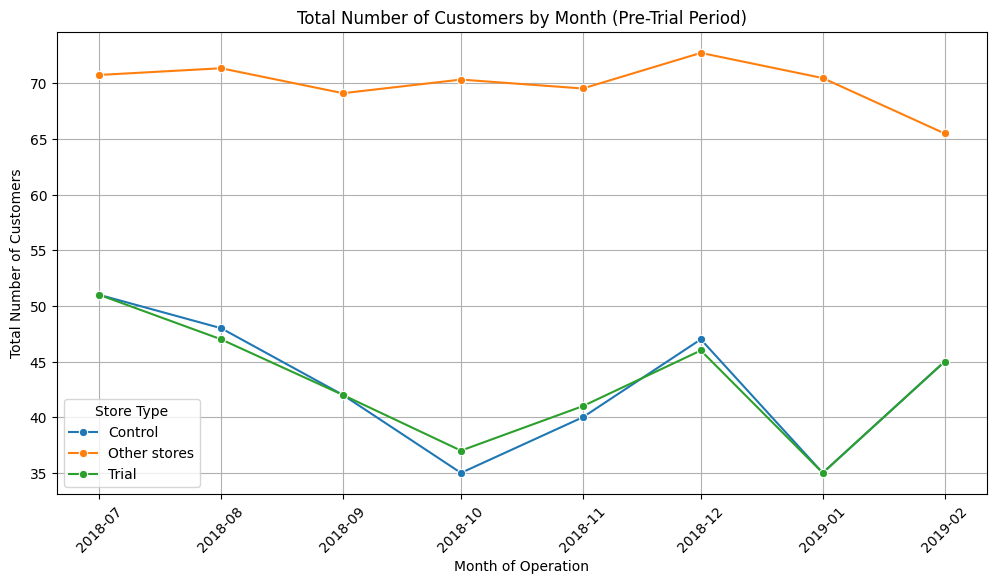

In [10]:
# Aggregate number of customers by month and store type
pastCustomers = measure_over_time.groupby(['YEARMONTH', 'Store_type'], as_index=False)['nCustomers'].mean()

#Convert YEARMONTH to datetime format
pastCustomers['TransactionMonth'] = pd.to_datetime(pastCustomers['YEARMONTH'].astype(str), format='%Y%m')


pastCustomers = pastCustomers[pastCustomers['YEARMONTH'] < 201903]
plt.figure(figsize=(12, 6))
sns.lineplot(data=pastCustomers, x='TransactionMonth', y='nCustomers', hue='Store_type', marker='o')


plt.xlabel("Month of Operation")
plt.ylabel("Total Number of Customers")
plt.title("Total Number of Customers by Month (Pre-Trial Period)")
plt.xticks(rotation=45)
plt.legend(title="Store Type")
plt.grid(True)
plt.show()


**Assessment of Trial.**

The trial period goes from the start of March 2019 to June 2019. We now want to see if there has been an
uplift in overall chip sales.

Start with scaling the control store’s sales to a level similar to control for any differences between the
two stores outside of the trial period.



In [11]:
# scaling factor
total_sales_trial = pre_trial_measures.loc[
    (pre_trial_measures['STORE_NBR'] == trial_store) & (pre_trial_measures['YEARMONTH'] < 201902),'totSales'].sum()

total_sales_control = pre_trial_measures.loc[
    (pre_trial_measures['STORE_NBR'] == control_store) & (pre_trial_measures['YEARMONTH'] < 201902),'totSales'].sum()

scalingFactorForControlSales = total_sales_trial / total_sales_control

#Apply scaling factor to control store's sales
measureOverTimeSales = measure_over_time.copy()
measureOverTimeSales.loc[measureOverTimeSales['STORE_NBR'] == control_store,
                         'controlSales'] = measureOverTimeSales['totSales'] * scalingFactorForControlSales

measureOverTimeSales.head()


,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,Store_type,controlSales
0,1,201807,206.9,49,1.061224,31.0,3.337097,Other stores,NaN
1,1,201808,176.1,42,1.023810,18.0,3.261111,Other stores,NaN
2,1,201809,278.8,59,1.050847,37.5,3.717333,Other stores,NaN
3,1,201810,188.1,44,1.022727,29.0,3.243103,Other stores,NaN
4,1,201811,192.6,46,1.021739,28.5,3.378947,Other stores,NaN


Calculate the percentage difference
between the scaled control sales and the trial store’s sales during the trial period.

In [12]:
# Merge scaled control sales with trial store sales
percentageDiff = measureOverTimeSales.loc[measureOverTimeSales['STORE_NBR'] == control_store,
                  ['YEARMONTH', 'controlSales']].merge(measureOverTimeSales.loc[measureOverTimeSales['STORE_NBR'] == trial_store,
                  ['YEARMONTH', 'totSales']],on='YEARMONTH')

#Calculate percentage difference
percentageDiff['percentageDiff'] = abs(percentageDiff['controlSales'] - percentageDiff['totSales']) / percentageDiff['controlSales']
percentageDiff.head()


,YEARMONTH,controlSales,totSales,percentageDiff
0,201807,297.565550,296.8,0.002573
1,201808,292.652187,255.5,0.126950
2,201809,233.998916,225.2,0.037602
3,201810,190.085733,204.5,0.075830
4,201811,216.597421,245.3,0.132516


Is the difference is significant?

In [13]:
#standard deviation of percentage difference in pre-trial period
stdDev = percentageDiff.loc[percentageDiff['YEARMONTH'] < 201902, 'percentageDiff'].std()

#degrees of freedom (pre-trial period has 8 months → 8-1 = 7)
degreesOfFreedom = 7  # Since we have 8 months in pre-trial, df = n-1

#Calculate t-value (difference from null hypothesis of 0)
percentageDiff['tValue'] = (percentageDiff['percentageDiff'] - 0) / stdDev

#Convert YEARMONTH to a proper date format
percentageDiff['TransactionMonth'] = pd.to_datetime(percentageDiff['YEARMONTH'].astype(str) + '01', format='%Y%m%d')

#Filter only trial period months (Feb 2019 to April 2019)
trial_t_values = percentageDiff.loc[(percentageDiff['YEARMONTH'] > 201901) & (percentageDiff['YEARMONTH'] < 201905),
                                    ['TransactionMonth', 'tValue']]

trial_t_values


,TransactionMonth,tValue
7,2019-02-01,1.183534
8,2019-03-01,7.339116
9,2019-04-01,12.476373


In [14]:
from scipy.stats import t
# Compute the 95th percentile (one-tailed)
t_critical = t.ppf(0.95, df=degreesOfFreedom)
t_critical


np.float64(1.894578605061305)

The t-value is much larger than the 95th percentile value of the t-distribution for March
and April - i.e. the increase in sales in the trial store in March and April is statistically greater than in the
control store.

Assessing this for number of customers

In [15]:
#Scale pre-trial control store customers to match trial store customers
scalingFactorForControlCust = (
    pre_trial_measures.loc[(pre_trial_measures["STORE_NBR"] == trial_store) & (pre_trial_measures["YEARMONTH"] < 201902), "nCustomers"].sum()
    / pre_trial_measures.loc[(pre_trial_measures["STORE_NBR"] == control_store) & (pre_trial_measures["YEARMONTH"] < 201902), "nCustomers"].sum()
)

# Apply the scaling factor
measureOverTimeCusts = measure_over_time.copy()
measureOverTimeCusts.loc[measureOverTimeCusts["STORE_NBR"] == control_store, "controlCustomers"] = (
    measureOverTimeCusts["nCustomers"] * scalingFactorForControlCust
)

#Categorize stores
measureOverTimeCusts["Store_type"] = measureOverTimeCusts["STORE_NBR"].apply(
    lambda x: "Trial" if x == trial_store else ("Control" if x == control_store else "Other stores")
)

#Calculate the percentage difference
percentageDiffCust = measureOverTimeCusts[measureOverTimeCusts["STORE_NBR"] == control_store][["YEARMONTH", "controlCustomers"]].merge(
    measureOverTimeCusts[measureOverTimeCusts["STORE_NBR"] == trial_store][["YEARMONTH", "nCustomers"]],
    on="YEARMONTH"
)

percentageDiffCust["percentageDiff"] = abs(percentageDiffCust["controlCustomers"] - percentageDiffCust["nCustomers"]) / percentageDiffCust["controlCustomers"]

percentageDiffCust


,YEARMONTH,controlCustomers,nCustomers,percentageDiff
0,201807,51.171141,51,0.003344
1,201808,48.161074,47,0.024108
2,201809,42.140940,42,0.003344
3,201810,35.117450,37,0.053607
4,201811,40.134228,41,0.021572
5,201812,47.157718,46,0.024550
6,201901,35.117450,35,0.003344
7,201902,45.151007,45,0.003344
8,201903,40.134228,50,0.245819
9,201904,30.100671,47,0.561427


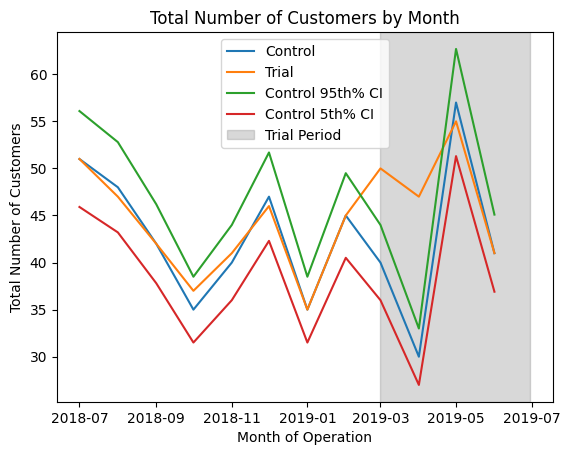

In [17]:
#Compute standard deviation for pre-trial period (before Feb 2019)
#stdDev = percentageDiffCust.loc[percentageDiffCust["YEARMONTH"] < 201902, "percentageDiff"].std()
#degreesOfFreedom = 7  # 8 months pre-trial, df = 8 - 1 = 7

#average number of customers per month for Trial & Control stores
pastCustomers = measureOverTimeCusts.groupby(["YEARMONTH", "Store_type"])["nCustomers"].mean().reset_index()

# Filter only Trial & Control stores
pastCustomers = pastCustomers[pastCustomers["Store_type"].isin(["Trial", "Control"])]

# 95th and 5th percentile confidence intervals
pastCustomers_Controls95 = pastCustomers[pastCustomers["Store_type"] == "Control"].copy()
pastCustomers_Controls95["nCustomers"] *= (1 + stdDev * 2)  # Upper bound
pastCustomers_Controls95["Store_type"] = "Control 95th% CI"

pastCustomers_Controls5 = pastCustomers[pastCustomers["Store_type"] == "Control"].copy()
pastCustomers_Controls5["nCustomers"] *= (1 - stdDev * 2)  # Lower bound
pastCustomers_Controls5["Store_type"] = "Control 5th% CI"

#Combine all data
trialAssessment = pd.concat([pastCustomers, pastCustomers_Controls95, pastCustomers_Controls5])

# YEARMONTH to datetime format for visualization
trialAssessment["TransactionMonth"] = pd.to_datetime(trialAssessment["YEARMONTH"].astype(str) + "01", format="%Y%m%d")


#plt.figure(figsize=(12, 6))
sns.lineplot(data=trialAssessment, x="TransactionMonth", y="nCustomers", hue="Store_type")

# Highlight the trial period (March 2019 - June 2019)
plt.axvspan(pd.to_datetime("2019-03-01"), pd.to_datetime("2019-06-30"), color="gray", alpha=0.3, label="Trial Period")

plt.xlabel("Month of Operation")
plt.ylabel("Total Number of Customers")
plt.title("Total Number of Customers by Month")
plt.legend()



The analysis aims to determine the impact of a trial period on chip sales at a specific store (Trial Store 77) by comparing its performance to a control store (Store 233).  The key findings are as follows:

**Control Store Selection:** A control store was chosen based on its similarity to the trial store in terms of pre-trial total sales and customer numbers.  This selection was made using a weighted average of correlation and magnitude distance metrics.  The visualizations of total sales and customer numbers before the trial period demonstrate that the chosen control store (Store 233) exhibits a similar trend to the trial store, providing a reliable baseline for comparison.

**Trial Period Impact on Sales:**  The analysis indicates that during the trial period (March-June 2019), the trial store's sales significantly outperformed the scaled control store's sales. The t-values calculated for March and April were significantly larger than the critical t-value, suggesting a statistically significant increase in sales at the trial store compared to the control.

**Trial Period Impact on Customer Numbers:** The analysis of customer numbers during the trial period shows that the number of customers at the trial store fell within the 95% confidence interval of the control store's scaled customer numbers. This suggests that the observed sales uplift wasn't primarily driven by an increase in customer traffic but likely by other factors like increased spending per customer, promotions, or product placements.

**Conclusion:** The trial period resulted in a statistically significant increase in sales at the trial store compared to the control store.  However, this increase was not accompanied by a corresponding increase in the number of customers.  Further investigation is needed to understand the factors driving the sales uplift, such as changes in average transaction value, product mix, or promotional activities.  The observed change in customer numbers is not statistically significant.
